# The problem of exchanging a key through an insecure channel

For Alice and Bob to comunicate securely they need to stablish a secret key before. For now we've assumed that they do so by meeting in person but what if... they can stablish the key through an insecure channel?. To understand how to do so we need first to understand the discrete logarithm problem. For a different explanation check this [post](https://sebastiaagramunt.medium.com/discrete-logarithm-problem-and-diffie-hellman-key-exchange-821a45202d26).

## Discrete logarithm problem

You may know logarithms from your math class at school. They are pretty simple. The function logarithm is normally represented as

$$y=\log_b(x)$$

where $x$, $y$ and $b$ are related by

$$x=b^y$$

here b is known as the base of the logarithm. The logarithm problem is the problem of finding $y$ knowing $b$ and $x$, i.e. calculate the logarithm of $x$ base $b$. This is straighforward, let's plot the logarithm function:

<Figure size 432x288 with 0 Axes>

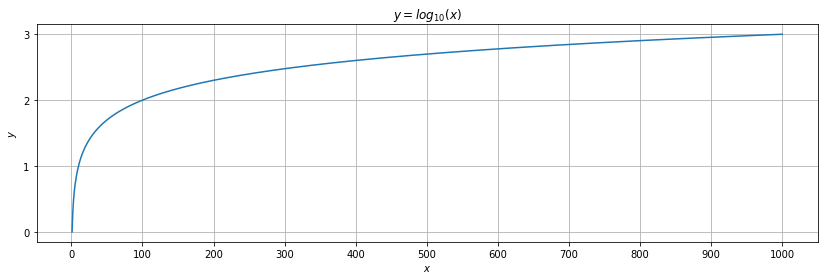

In [1]:
import matplotlib.pyplot as plt
import numpy as np

xmax = 1000
ymax = np.log10(xmax)

x = np.linspace(1, xmax, xmax)
y = np.log10(x)

plt.clf()

fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, y)

ax.set_xticks(np.arange(0, xmax+1, xmax//10))
ax.set_yticks(np.arange(0, ymax+1, 1))

ax.set_title("$y=log_{10}(x)$")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
#ax.set_xscale('log')
plt.grid()


It is easy to find $y$ knowing $x$ and $b$ (in this case $b$=10). What if we move to the modulo $p$ with product group?

The discrete logarithm problem is the problem of **finding $y$** knowing $x$, $p$ (prime) and $g$ (generator for the group of $p$) such that:

$$x=g^y \textit{(mod p)}$$

We take $g$ because it can generate all the possible values $x$ and therefore is more difficult to find $y$ such that the equation above is true. Let's plot this for a certain $p$ and $g$.

In [14]:
from crypto import GeneratePrimeGeneratorPair

p, g = GeneratePrimeGeneratorPair(8)

print(f"Prime number:\n\t{p}\nGenerator:\n\t{g}")

Prime number:
	227
Generator:
	52


In [15]:
y = np.arange(1, p)
x = np.array([pow(g, int(y_), p) for y_ in y])

<Figure size 432x288 with 0 Axes>

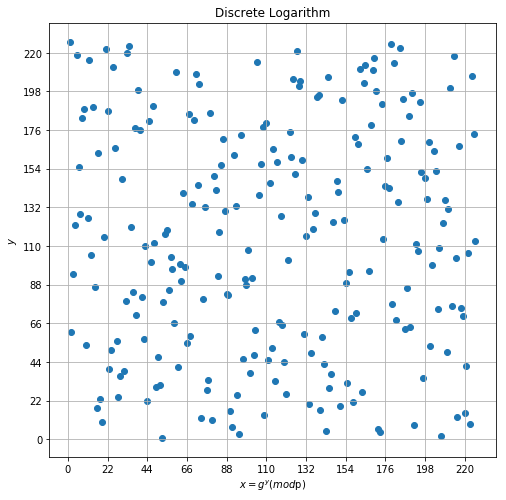

In [16]:
plt.clf()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x, y)

ax.set_xticks(np.arange(0, p+1, p//10))
ax.set_yticks(np.arange(0, p+1, p//10))

ax.set_title("Discrete Logarithm")
ax.set_xlabel("$x=g^y (mod $p)")
ax.set_ylabel("$y$")
#ax.set_xscale('log')
plt.grid()

The discrete logarithm problem is a difficult problem to solve, there's a priori no way of finding $y$, we have to test all the possible values of $y$.

## How hard is it to find $y$ in the DLP?

We are going to solve the DLP: First we set up the problem by generating a random prime number $p$ of $n$ bits and a corresponding generator $g$. Then randomly pick a value $x$ (spoiler, this will be our secret key) in between 0 and $p$-1. Now the "attack" by randomly sampling values of $y$ in between 0 and $p$-1 and compute $g^y$(mod $p$). When we find the $y$ such that $x=g^y$(mod $p$), then we know the secret $x$.

In [58]:
p, g = GeneratePrimeGeneratorPair(20)

print(f"Prime number:\n\t{p}\nGenerator:\n\t{g}")

Prime number:
	702193
Generator:
	470528


In [59]:
from random import randrange

def find_y(x:int, p:int , g:int, max_iter:int = 5000000) -> int:
    i = 0
    while i < max_iter:
        y = randrange(1, p)
        i += 1
        if pow(g, y, p) == x:
            return y
    return None

In [64]:
%%time
x = randrange(1, p)
y = find_y(x, p, g)

assert x==pow(g, y, p), "x not found"

#print(f"{x}, {y}")

CPU times: user 2.09 s, sys: 13.7 ms, total: 2.1 s
Wall time: 2.11 s


In [65]:
from time import time
from random import seed 

times = []
trials = 20
seed(4)

for bits in range(4, 18, 1):
    count = 0
    avg_times = []
    while count < trials:
        p, g = GeneratePrimeGeneratorPair(bits)
        x = randrange(1, p)

        t_start = time()
        y = find_y(x, p, g, 9999999999)
        t_end = time()
        
        avg_times.append(t_end-t_start)
        count += 1
    print(f"bits: {bits}, time: {np.mean(np.array(avg_times))}")
    times.append((bits, np.mean(np.array(avg_times))))

bits: 4, time: 3.5250186920166014e-05
bits: 5, time: 6.15239143371582e-05
bits: 6, time: 0.00011200904846191407
bits: 7, time: 0.00018078088760375977
bits: 8, time: 0.000313568115234375
bits: 9, time: 0.0008934497833251953
bits: 10, time: 0.0014163494110107423
bits: 11, time: 0.0032366633415222166
bits: 12, time: 0.006123685836791992
bits: 13, time: 0.008507251739501953
bits: 14, time: 0.018885231018066405
bits: 15, time: 0.05806785821914673
bits: 16, time: 0.11601490974426269
bits: 17, time: 0.19826747179031373


<Figure size 432x288 with 0 Axes>

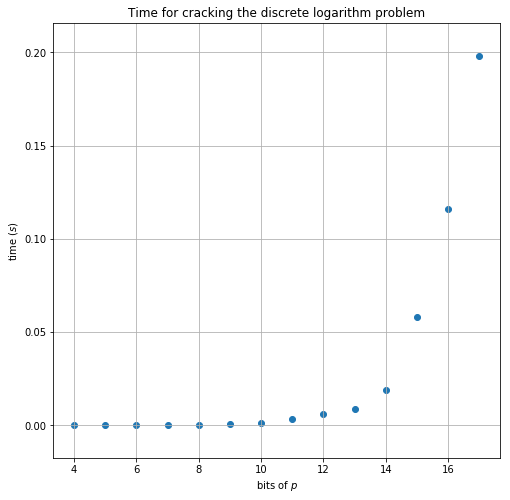

In [67]:
plt.clf()

bits = [x[0] for x in times]
t = [x[1] for x in times]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(bits, t)

ax.set_title("Time for cracking the discrete logarithm problem")
ax.set_xlabel("bits of $p$")
ax.set_ylabel("time ($s$)")

plt.grid()

As the number of bits for $p$ increases, the difficulty to find $y$ increases logarithmically. In fact, we can view this problem as finding a number $y$ that we know has 2^{n} possibilities ($n$ is the number of bits), one for each bit, then the probability to guess correctly $y$ in one trial will be

$$P(n) = \frac{1}{2^n}$$

Therefore the calculation time increases as $2^n$. At this point we can define the **concrete approach definition for computational security** (see An introduction to modern cryptography): 

A scheme is ($t$, $e$) secure if any adversary running at most during time $t$ succeeds to break the code within probability at most $e$. Say a supercomputer can do $c$ tests of $y$ per unit time, then at time $t$ he will have run $c$*$t$ checks. The probability of guessing the key of length $n$ bits is

$$P(c, t, n) = \frac{ct}{2^n}$$